In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kabirjolly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
mtsamples = pd.read_csv('./mtsamples.csv')
mtsamples.head(3)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."


In [4]:
# collect and disregard datapoints that are associated with types of notes
cols_to_remove = [
    " Consult - History and Phy.",
    " SOAP / Chart / Progress Notes",
    " Discharge Summary",
    " Emergency Room Reports",
    " Office Notes",
    " Letters"
]
mtsamples = mtsamples[~mtsamples['medical_specialty'].isin(cols_to_remove)]

# remove rows with missing transcriptions
mtsamples = mtsamples.dropna(subset=['transcription'])
mtsamples['medical_specialty'].value_counts()

medical_specialty
 Surgery                       1088
 Cardiovascular / Pulmonary     371
 Orthopedic                     355
 Radiology                      273
 General Medicine               259
 Gastroenterology               224
 Neurology                      223
 Urology                        156
 Obstetrics / Gynecology        155
 ENT - Otolaryngology            96
 Neurosurgery                    94
 Hematology - Oncology           90
 Ophthalmology                   83
 Nephrology                      81
 Pediatrics - Neonatal           70
 Pain Management                 61
 Psychiatry / Psychology         53
 Podiatry                        47
 Dermatology                     29
 Cosmetic / Plastic Surgery      27
 Dentistry                       27
 Physical Medicine - Rehab       21
 Sleep Medicine                  20
 Endocrinology                   19
 Bariatrics                      18
 IME-QME-Work Comp etc.          16
 Chiropractic                    14
 Rheumatol

## Naive Bayes Baseline Approach

### Preprocessing

In [5]:
# get data
x = mtsamples['transcription'].values
Y = mtsamples['medical_specialty'].values

print(x.shape)
print(Y.shape)

(4028,)
(4028,)


In [6]:
# lowercasing
x = [doc.lower() for doc in x]

In [7]:
# removing punctuation
import string

x = [''.join(c for c in doc if c not in string.punctuation) for doc in x]

In [8]:
# tokenization
from nltk import word_tokenize

x = np.array([np.array(word_tokenize(doc)) for doc in x], dtype=object)

In [9]:
# stop word removal
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

x = np.array([[word for word in doc if word not in stop_words] for doc in x], dtype=object)

In [10]:
# stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
stemmed = np.array([[porter.stem(word) for word in doc] for doc in x], dtype=object)

In [11]:
# cast all lists to numpy arrays
x = np.array([np.array(doc) for doc in stemmed], dtype=object)

### Feature Extraction

In [12]:
# use bag of words approach to create fixed length vectors
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
x = vectorizer.fit_transform([' '.join(doc) for doc in x]).toarray()
print(x.shape)

(4028, 37666)


In [13]:
Y.shape

(4028,)

### Training

In [14]:
# split into train and test datasets
from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.4, shuffle=True)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)


x_train shape:  (2416, 37666)
x_test shape:  (1612, 37666)
Y_train shape:  (2416,)
Y_test shape:  (1612,)


In [15]:
# initialize model
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

In [16]:
# train model
model.fit(x_train, Y_train)

MultinomialNB()

### Predictions

In [17]:
# generate model predictions
Y_pred = model.predict(x_test)

### Model Evaluation

In [18]:
# create confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, Y_pred)
print(conf_mat)
print(conf_mat.shape)

[[  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   3   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 249   5]
 [  0   0   0 ...   0  34   5]]
(34, 34)


<AxesSubplot: >

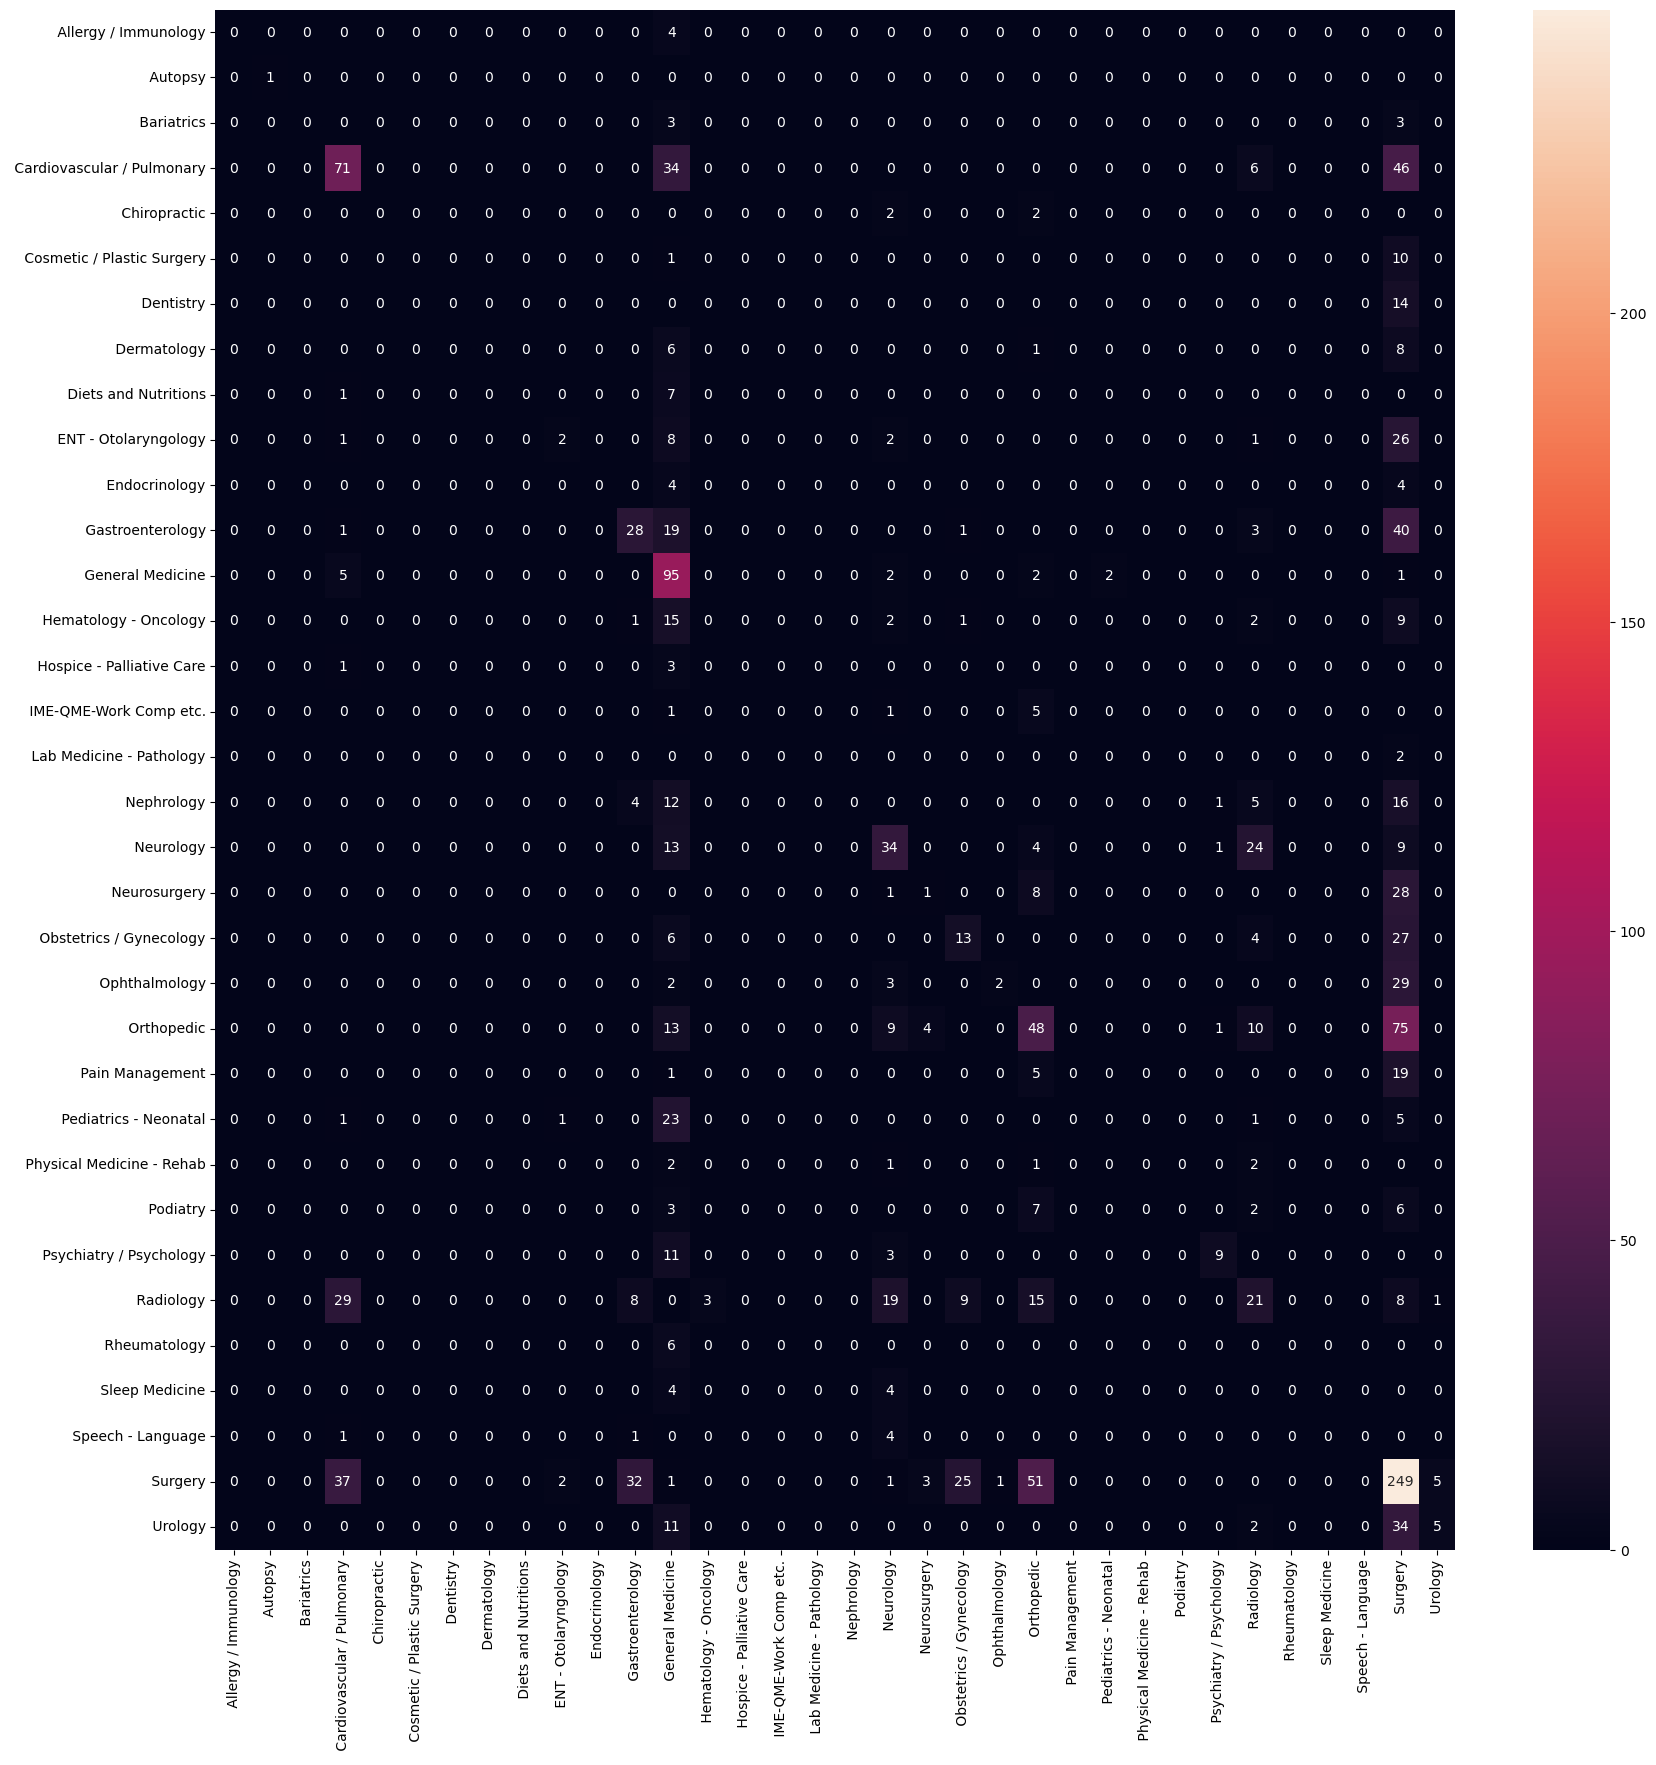

In [19]:
# plot confusion matrix using seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=np.unique(Y), yticklabels=np.unique(Y))

In [20]:
# evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(Y_test, Y_pred, average='macro', zero_division=0))
print("Recall: ", recall_score(Y_test, Y_pred, average='macro', zero_division=0))
print("F1 Score: ", f1_score(Y_test, Y_pred, average='macro', zero_division=0))

Precision:  0.1812454628468191
Recall:  0.14768798386785648
F1 Score:  0.14154742956037583


In [23]:
# classwise precision, recall and f1 score
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred, zero_division=0))

                             precision    recall  f1-score   support

       Allergy / Immunology       0.00      0.00      0.00         4
                    Autopsy       1.00      1.00      1.00         1
                 Bariatrics       0.00      0.00      0.00         6
 Cardiovascular / Pulmonary       0.48      0.45      0.47       157
               Chiropractic       0.00      0.00      0.00         4
 Cosmetic / Plastic Surgery       0.00      0.00      0.00        11
                  Dentistry       0.00      0.00      0.00        14
                Dermatology       0.00      0.00      0.00        15
       Diets and Nutritions       0.00      0.00      0.00         8
       ENT - Otolaryngology       0.40      0.05      0.09        40
              Endocrinology       0.00      0.00      0.00         8
           Gastroenterology       0.38      0.30      0.34        92
           General Medicine       0.31      0.89      0.46       107
      Hematology - Oncology      